In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
import torch.nn.utils.weight_norm as weight_norm
import torch.nn.functional as F
import numpy as np
import scipy as sp
from scipy.stats import norm, shapiro, binom
from scipy.special import beta

import matplotlib.pyplot as plt
import random
import time as t
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype, fetch_openml, fetch_20newsgroups
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import os
import urllib
import gzip
import zipfile
import json
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
import datasets
from datasets import load_dataset
import seaborn as sns
import ipynbname
from collections import defaultdict

notebook_name = ipynbname.name()
# from torchtime.data import PhysioNet2012
# from torchtime.collate import packed_sequence

In [2]:
# ✅ 1. Config

device_id = 1
device = "cuda:"+str(device_id) if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 128
DATA_PATH = './data'
SEED = 42
torch.manual_seed(SEED)

# ✅ Load data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 3072
])

# ✅ Load full training and test sets
train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [3]:
class MLP(nn.Module):
    # For UCI Income: input_dim=X_train_tensor.shape[1], hidden_dims=[64, 32], output_dim=2,
    # For CoverType input_dim=54, hidden_dims=[256, 128, 64], output_dim=7,
    # CIFAR-10 its input_dim=3072, hidden_dims=[2048, 1024, 1024, 512, 256, 128], output_dim=10,
    # CIFAR-100 its input_dim=3072, hidden_dims=[2048, 1024, 1024, 512, 256, 128], output_dim=100,
    # For FashionMNIST its input_dim=784, hidden_dims=[512, 256, 128], output_dim=10, dropout=0.2,
    # For Yelp dataset input_dim=10000, hidden_dims=[512], output_dim=2, 
    # For 20Newsgroups input_dim=2000, hidden_dims=[512, 256, 128], num_classes=20
    def __init__(self, input_dim=3072, hidden_dims=[2048, 1024, 1024, 512, 256, 128], output_dim=10, dropout=0.3, activation_fn=nn.ReLU, use_mask=True, threshold=1):
        super(MLP, self).__init__()
        self.activation = activation_fn()
        self.use_mask = use_mask
        layers = []
        dims = [input_dim] + hidden_dims
        self.table = {}
        x_vals = np.linspace(0,1,100000)
        for b in dims:
            self.table[b] = sp.special.betainc(1/2, 0.5*(b - 1), x_vals)

        for i in range(len(dims) - 1):
            layers += [
                MaskedLinear(dims[i], dims[i+1], use_mask=self.use_mask, threshold=threshold, table=self.table),
                # nn.BatchNorm1d(dims[i+1]),
                self.activation,
                # nn.Dropout(dropout)
            ]
    
        layers.append(MaskedLinear(dims[-1], output_dim, use_mask=self.use_mask, threshold=threshold, table=self.table))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, threshold=1, use_mask=True, table={}):
        super().__init__(in_features, out_features, bias)
        self.threshold = torch.tensor(threshold) #-torch.log10()
        self.use_mask = use_mask
        self.register_buffer("entropy", torch.tensor(0.0))
        self.table = table
        self.register_buffer("w_values", torch.zeros_like(self.weight))
        
    def wval(self, M):
        a = t.time()
        L = M.shape[1] if M.ndim == 2 else M.shape[1] * M.shape[2] * M.shape[3]

        alpha = torch.as_tensor(1/2, dtype=M.dtype, device=M.device)
        beta = torch.as_tensor((L-1)/2, dtype=M.dtype, device=M.device)
    
        # Normalize each weight vector going from a node in A to layer B
        M_normed = F.normalize(M, p=2, dim=1)
        
        M_clamped = torch.clamp(M_normed**2, min=1e-8, max=1-1e-8)

        M_cpu = M_clamped.detach().cpu().numpy()
        alpha_cpu = float(alpha.item())  # scalar
        beta_cpu = float(beta.item())    # scalar
        
        index_matrix = np.round(100000 * M_cpu).astype(int)
        
        # Optional: clamp to [0, 100] just in case of rounding errors
        index_matrix = np.clip(index_matrix, 0, 100000)
        
        # Step 2: Use advanced NumPy indexing
        table_vals = np.array(self.table[L])  # Make sure this is a NumPy array
        cdf_np = table_vals[index_matrix]     # Fast lookup for entire matrix
        
        cdf = torch.tensor(cdf_np, dtype=M_clamped.dtype, device=M_clamped.device)

        beta_surv = torch.clamp(1 - cdf, min=1e-8, max=1-1e-8)  # Survival function
        
        w_val = -torch.log(beta_surv)

        assert w_val.shape == M.shape

        return w_val

    def forward(self, input):
        if self.use_mask:
            # Compute significance
            self.w_values = self.wval(self.weight)
    
            # Create binary mask
            mask = (self.w_values >= self.threshold).float()
    
            # Apply the mask (zero out insignificant weights)
            masked_weight = self.weight * mask
        else:
            masked_weight = self.weight
            self.w_values = self.wval(self.weight)

        flat_M = torch.flatten(masked_weight)
        flat_M_2 = flat_M.pow(2)

        entropy_value = sp.stats.entropy(flat_M_2.detach().cpu().numpy())
        ent_tensor = torch.tensor(entropy_value)
        self.entropy.copy_(ent_tensor)
        return F.linear(input, masked_weight, self.bias)



In [4]:
def save_run_data_txt(
    base_dir, model, config, train_losses, train_accuracies,
    test_losses, test_accuracies
):
    # Create a unique folder name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = (
        f"{timestamp}_act-{config['activation']}_mask-{config['use_mask']}"
        f"_thresh-{round(config['threshold'],2)}_reg-{config['regularization']}_epochs-{config['epochs']}-{notebook_name}"
    )
    path = os.path.join(base_dir, folder_name)
    os.makedirs(path, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(path, "model.pth"))

    # Save run configuration
    with open(os.path.join(path, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # Helper function to write a list of floats to a .txt file
    def write_list(filename, values):
        with open(os.path.join(path, filename), "w") as f:
            for v in values:
                f.write(f"{v:.6f}\n")

    # Save all metrics
    write_list("train_losses.txt", train_losses)
    write_list("train_accuracies.txt", train_accuracies)
    write_list("test_losses.txt", test_losses)
    write_list("test_accuracies.txt", test_accuracies)

    print(f"Run data saved to {path}")


In [5]:
def train_and_collect_metrics(
    train_loader,
    test_loader,
    act,
    use_mask,
    regularization=None,
    lambda_reg=0.0,
    initial_weights=None,
    epochs=5,
    the_device='cpu',
    threshold=1,
):
    model = MLP(activation_fn=act, use_mask=use_mask, threshold=threshold).to(the_device)
        
    if initial_weights is not None:
        model.load_state_dict({k: v.clone().to(the_device) for k, v in initial_weights.items()})

    model = model.to(the_device)
    model = nn.DataParallel(model, device_ids=[device_id])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(the_device), labels.to(the_device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            if regularization == "L1" and lambda_reg > 0:
                reg_term = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * reg_term
            elif regularization == "L2" and lambda_reg > 0:
                reg_term = sum((p ** 2).sum() for p in model.parameters())
                loss += lambda_reg * reg_term

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predicted = output.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

        # Compute test loss every 10 epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(the_device), labels.to(the_device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    predicted = outputs.argmax(dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_acc = 100 * correct / total
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_acc)
            print(f"[Epoch {epoch+1}] Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Final test evaluation
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(the_device), labels.to(the_device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = total_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"[use_mask={use_mask}, reg={regularization}] Final Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}")
    
    
    config = {
    "activation": act.__name__ if hasattr(act, "__name__") else str(act),
    "use_mask": use_mask,
    "threshold": threshold,
    "regularization": regularization,
    "lambda_reg": lambda_reg,
    "epochs": epochs,
    "device": the_device,
    }

    save_run_data_txt(
        base_dir="runs_"+notebook_name,
        model=model,
        config=config,
        train_losses=train_losses,
        train_accuracies=train_accuracies,
        test_losses=test_losses,
        test_accuracies=test_accuracies,
    )
    
    return model.module, test_losses, test_accuracies, train_losses, train_accuracies


In [6]:
torch.manual_seed(42)
EPOCHS = 80
#THRESHOLD = 0.4

baseline_model = MLP(activation_fn = nn.ReLU, use_mask=False, threshold=0.7).cpu()
# Save baseline weights
initial_weights = {k: v.clone().detach().cpu() for k, v in baseline_model.state_dict().items()}

# Run all configurations
model_results = {}
test_losses = {}
times = {}
test_accs = {}
train_losses = {}
train_accs = {}

configs = [
    # ("ReLU_NoMask_NoReg", nn.ReLU, False, None, 0.0, 0.7),
    # ("ReLU_NoMask_L1", nn.ReLU, False, "L1", 1e-6, 0.7),
    # ("ReLU_NoMask_L2", nn.ReLU, False, "L2", 1e-6, 0.7),
    # ("ReLU_Mask_NoReg_t1", nn.ReLU, True, None, 0.0, -np.log(0.90)),
    # ("ReLU_Mask_NoReg_t2", nn.ReLU, True, None, 0.0, -np.log(0.75)),
    # ("ReLU_Mask_NoReg_t3", nn.ReLU, True, None, 0.0, -np.log(0.50)),
    ("ReLU_Mask_NoReg_t4", nn.ReLU, True, None, 0.0, -np.log(0.25)),
    # ("ReLU_Mask_NoReg_t5", nn.ReLU, True, None, 0.0, -np.log(0.10)),
    # ("Sigmoid_NoMask_NoReg", nn.Sigmoid, False, None, 0.0, 0.7),
    # ("Sigmoid_NoMask_L1", nn.Sigmoid, False, "L1", 1e-6, 0.7),
    # ("Sigmoid_Mask_NoReg", nn.Sigmoid, True, None, 0.0, 0.7),
]

start = t.time()

for label, act, use_mask, reg_type, lambd, thresh in configs:
    iter_i = t.time()
    model, test_loss, test_acc, train_loss, train_acc = train_and_collect_metrics(train_loader, test_loader, act, use_mask, reg_type, lambd, initial_weights, epochs=EPOCHS, the_device=device, threshold=thresh)
    test_losses[label] = test_loss
    model_results[label] = model
    test_accs[label] = test_acc
    train_losses[label] = train_loss
    train_accs[label] = train_acc

    iter_f = t.time()
    delta = iter_f - iter_i
    print(delta)
    times[label] = delta
    
total = t.time() - start
print(total/60)       

Epoch 1/80 - Train Loss: 2.1000, Train Accuracy: 17.93%
Epoch 2/80 - Train Loss: 2.0237, Train Accuracy: 21.15%
Epoch 3/80 - Train Loss: 1.9252, Train Accuracy: 26.29%
Epoch 4/80 - Train Loss: 1.8417, Train Accuracy: 30.95%
Epoch 5/80 - Train Loss: 1.7969, Train Accuracy: 33.47%
[Epoch 5] Test Loss: 1.7678, Test Accuracy: 34.46%
Epoch 6/80 - Train Loss: 1.7553, Train Accuracy: 34.96%
Epoch 7/80 - Train Loss: 1.7142, Train Accuracy: 36.86%
Epoch 8/80 - Train Loss: 1.6783, Train Accuracy: 38.37%
Epoch 9/80 - Train Loss: 1.6464, Train Accuracy: 39.54%
Epoch 10/80 - Train Loss: 1.6194, Train Accuracy: 40.45%
[Epoch 10] Test Loss: 1.6258, Test Accuracy: 40.15%
Epoch 11/80 - Train Loss: 1.5919, Train Accuracy: 41.58%
Epoch 12/80 - Train Loss: 1.5685, Train Accuracy: 42.60%
Epoch 13/80 - Train Loss: 1.5426, Train Accuracy: 43.56%
Epoch 14/80 - Train Loss: 1.5250, Train Accuracy: 44.16%
Epoch 15/80 - Train Loss: 1.5020, Train Accuracy: 45.13%
[Epoch 15] Test Loss: 1.5184, Test Accuracy: 44.60%

In [7]:
all_entropies = {}
for label, the_model in model_results.items():
    entropies = []
    for name, layer in the_model.named_modules():
        if isinstance(layer, (MaskedLinear)):
            entropies.append(layer.entropy.cpu().item())
    all_entropies[label] = entropies

all_entropies

{'ReLU_Mask_NoReg_t4': [12.982451438903809,
  11.052258491516113,
  11.124748229980469,
  10.653677940368652,
  9.426321983337402,
  8.133378982543945,
  5.212383270263672]}

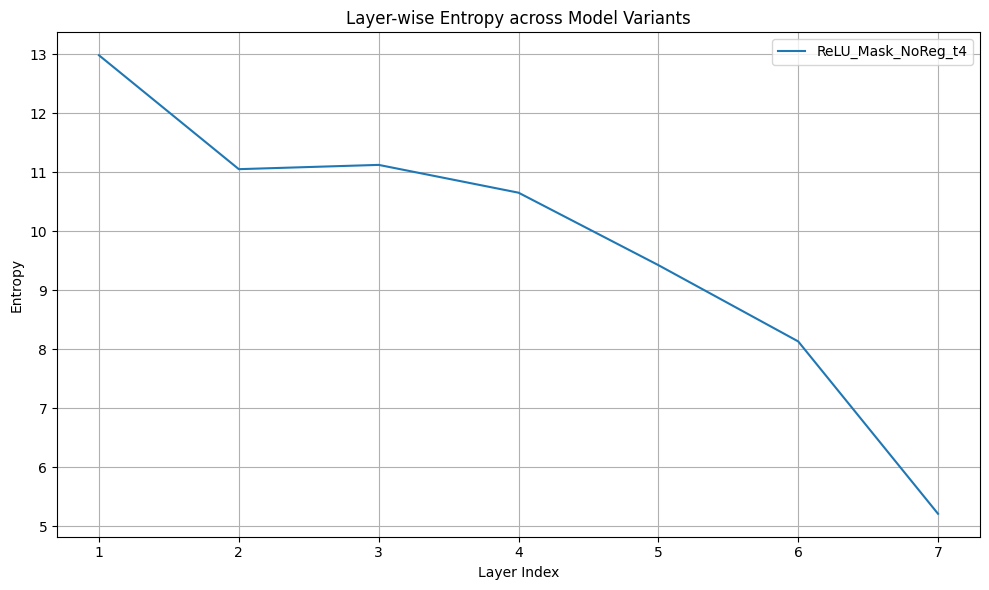

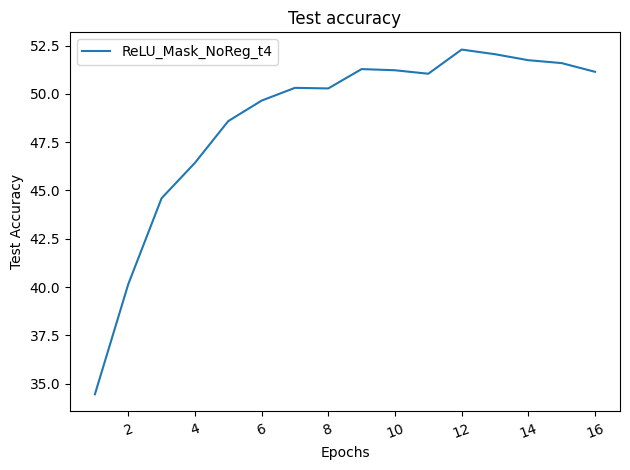

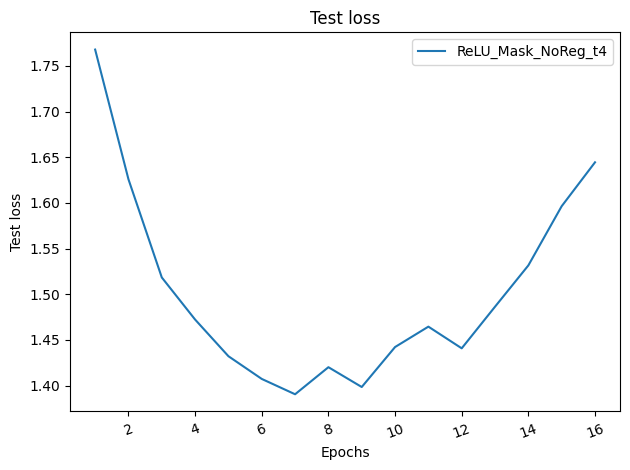

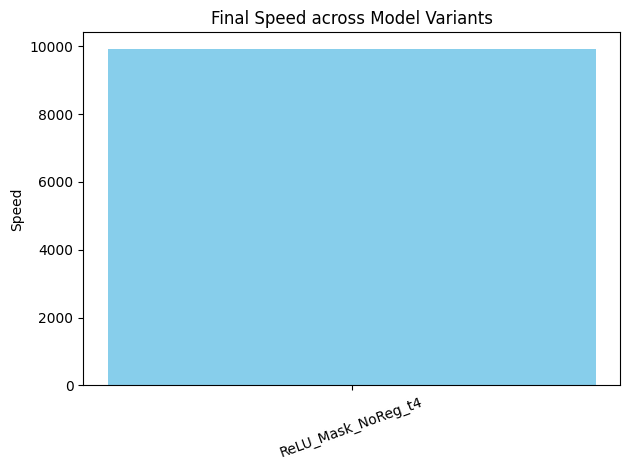

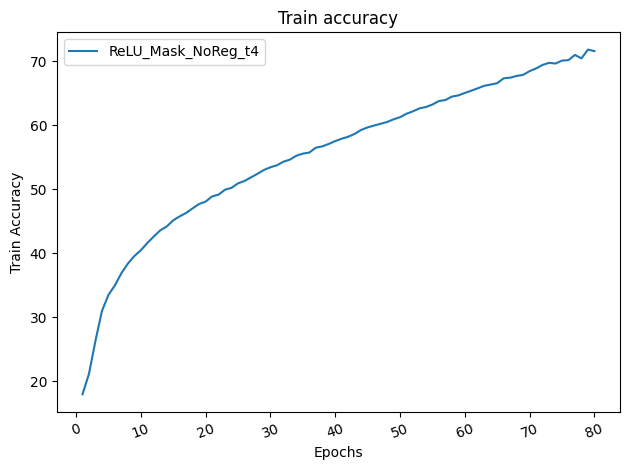

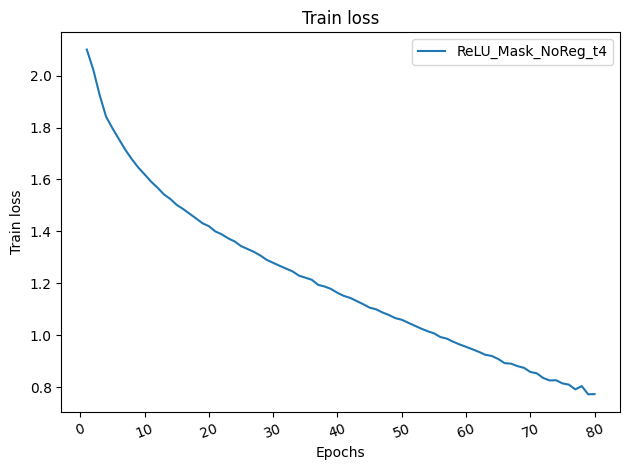

In [8]:
# Ensure plot directory exists
plot_dir = "runs_"+notebook_name+"/"+str(datetime.now().strftime("%Y%m%d_%H%M%S"))+"_plots"
os.makedirs(plot_dir, exist_ok=True)

# Plotting layer-wise entropy
plt.figure(figsize=(10, 6))
for label, entropies in all_entropies.items():
    plt.plot(range(1, len(entropies)+1), entropies, label=label)
plt.xlabel('Layer Index')
plt.ylabel('Entropy')
plt.title('Layer-wise Entropy across Model Variants')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Entropy.png")
plt.show()

# Test accuracy
plt.figure()
for label, accs in test_accs.items():
    plt.plot(range(1, len(accs)+1), accs, label=label)
plt.title("Test accuracy")
plt.ylabel('Test Accuracy')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Test_Accuracy.png")
plt.show()

# Test loss
plt.figure()
for label, loss in test_losses.items():
    plt.plot(range(1, len(loss)+1), loss, label=label)
plt.title("Test loss")
plt.ylabel('Test loss')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Test_loss.png")
plt.show()

# Speed
plt.figure()
plt.bar(times.keys(), times.values(), color='skyblue')
plt.ylabel('Speed')
plt.title('Final Speed across Model Variants')
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f"{plot_dir}/Speed.png")
plt.show()

# Train accuracy
plt.figure()
for label, accs in train_accs.items():
    plt.plot(range(1, len(accs)+1), accs, label=label)
plt.title("Train accuracy")
plt.ylabel('Train Accuracy')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Train_Accuracy.png")
plt.show()

# Train loss
plt.figure()
for label, loss in train_losses.items():
    plt.plot(range(1, len(loss)+1), loss, label=label)
plt.title("Train loss")
plt.ylabel('Train loss')
plt.xlabel("Epochs")
plt.xticks(rotation=20)
plt.tight_layout()
plt.legend()
plt.savefig(f"{plot_dir}/Train_loss.png")
plt.show()


In [9]:
def get_squared_weight_matrix(layer):
    # # For Conv layers, flatten input/output dimensions
    # if isinstance(layer, MaskedConv):
    #     # Shape: [out_channels, in_channels, kH, kW]
    #     M = layer.weight.view(layer.out_channels, -1)  # [out_c, in_c * kH * kW]
    if isinstance(layer, MaskedLinear):
        # Shape: [out_features, in_features]
        M = layer.weight
        W = torch.pow(10,-layer.wval(layer.weight))
    else:
        return None
    return M, W

def compute_g_value(model):
    layers = []
    W_vals = []
    for layer in model.modules():
        if isinstance(layer, (MaskedLinear)):
            M, W = get_squared_weight_matrix(layer)
            if M is not None:
                layers.append(M)
            if W is not None:
                W_vals.append(W)
    numer = 0.0
    denom = 0.0

    for i in range(len(layers) - 1):
        M1 = layers[i]
        M2 = layers[i+1]

        # M1: [out1, in1]; M2: [out2, in2] → treat shared dim as "middle"
        # So transpose M1 to [in1, out1] and M2 to [in2, out2]
        # sum over matching dimension (out1 == in2)
        M1_sq = M1.pow(2)  # shape: [out1, in1]
        M2_sq = M2.pow(2)  # shape: [out2, in2]
        
        # Align dimension for matching: M1.T: [in1, out1], M2: [out2, in2] ⇒ match on out1 == in2
        if M1.shape[0] != M2.shape[1]:
            # Skip incompatible shapes
            continue

        # Compute: sum_j (sum_i w_{ij}^2) * (sum_k w_{jk}^2)
        # That is, for each shared index j (layer output/input), multiply the sums of incoming and outgoing squared weights
        incoming = M1_sq.sum(dim=1)  # size: [out1] == [shared]
        outgoing = M2_sq.sum(dim=0)  # size: [in2] == [shared]
        numer += (incoming * outgoing).sum().item()

    for i in range(len(layers) - 1):
        M1 = layers[i]
        M2 = layers[i+1]

        W1 = W_vals[i]
        W2 = W_vals[i+1]
        
        # M1: [out1, in1]; M2: [out2, in2] → treat shared dim as "middle"
        # So transpose M1 to [in1, out1] and M2 to [in2, out2]
        # sum over matching dimension (out1 == in2)
        M1_sq = M1.pow(2) / W1
        M2_sq = M2.pow(2) / W2

        # Align dimension for matching: M1.T: [in1, out1], M2: [out2, in2] ⇒ match on out1 == in2
        if M1.shape[0] != M2.shape[1]:
            # Skip incompatible shapes
            continue

        # Compute: sum_j (sum_i w_{ij}^2) * (sum_k w_{jk}^2)
        # That is, for each shared index j (layer output/input), multiply the sums of incoming and outgoing squared weights
        incoming = M1_sq.sum(dim=1)  # size: [out1] == [shared]
        outgoing = M2_sq.sum(dim=0)  # size: [in2] == [shared]
        denom += (incoming * outgoing).sum().item()
        torch.set_printoptions(profile="default")

    return numer/denom


In [10]:
print("Regarding aggregated w-value")
for label in model_results.keys():
    print(label)
    print(compute_g_value(model_results[label]))
#compute_g_value(model_results["ReLU_NoMask_NoReg"])


Regarding aggregated w-value
ReLU_Mask_NoReg_t4
3.778707331668604e-36


In [11]:
def plot_weight_distributions(model=None, weight_data=None, model_name=None):
    """
    Plot weight and w-value histograms for each layer, either from:
    - a model (with .wval method on layers)
    - OR a dict (state_dict-style) with keys like 'layer.weight' and 'layer.w_values'
    """
    if model is None and weight_data is None:
        raise ValueError("Provide either a model or weight_data")

    weight_layers = []
    wval_layers = []
    layer_names = []

    if weight_data is not None:
        # Group .weight and .w_values by layer name
        grouped = defaultdict(dict)
        for full_name, tensor in weight_data.items():
            *layer_parts, attr = full_name.split('.')
            layer_name = '.'.join(layer_parts)
            grouped[layer_name][attr] = tensor

        for layer_name, tensors in grouped.items():
            if "weight" in tensors and "w_values" in tensors:
                try:
                    W = tensors["weight"].detach().cpu().flatten().numpy()
                    W_val = tensors["w_values"].detach().cpu().flatten().numpy()
                    weight_layers.append(W)
                    wval_layers.append(W_val)
                    layer_names.append(layer_name)
                except Exception as e:
                    print(f"Skipping {layer_name} due to error: {e}")

    elif model is not None:
        # Use the model's layers directly
        for name, layer in model.named_modules():
            if hasattr(layer, "weight") and hasattr(layer, "w_values"):
                try:
                    W = layer.weight.detach().cpu().flatten().numpy()
                    #W_val = layer.wval(layer.weight).detach().cpu().flatten().numpy()
                    W_val = layer.w_values.detach().cpu().flatten().numpy()
                    weight_layers.append(W)
                    wval_layers.append(W_val)
                    layer_names.append(name)
                except Exception as e:
                    print(f"Skipping layer {name} due to error: {e}")

    num_layers = len(weight_layers)
    if num_layers == 0:
        print("No valid layers found with both weights and w-values.")
        return

    plt.figure(figsize=(12, 4 * num_layers))

    # Plot weights
    for i, (weights, name) in enumerate(zip(weight_layers, layer_names)):
        plt.subplot(num_layers, 2, 2 * i + 1)
        sns.histplot(weights, binwidth=0.01, kde=False, color='steelblue')
        plt.title(f"Weight Distribution - {name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.xlim([-1, 1])

    # Plot w-values
    for i, (wvals, name) in enumerate(zip(wval_layers, layer_names)):
        plt.subplot(num_layers, 2, 2 * i + 2)
        sns.histplot(wvals, binwidth=0.1, kde=False, color='darkorange')
        plt.title(f"W-Value Distribution - {name}")
        plt.xlabel("W-Value")
        plt.ylabel("Frequency")
        plt.xlim([0, 4])

    plt.tight_layout()
    #os.makedirs(plot_dir+"-"+model_name, exist_ok=True)
    plt.savefig(f"{plot_dir}-{model_name}-W_WVs.png")
    plt.show()


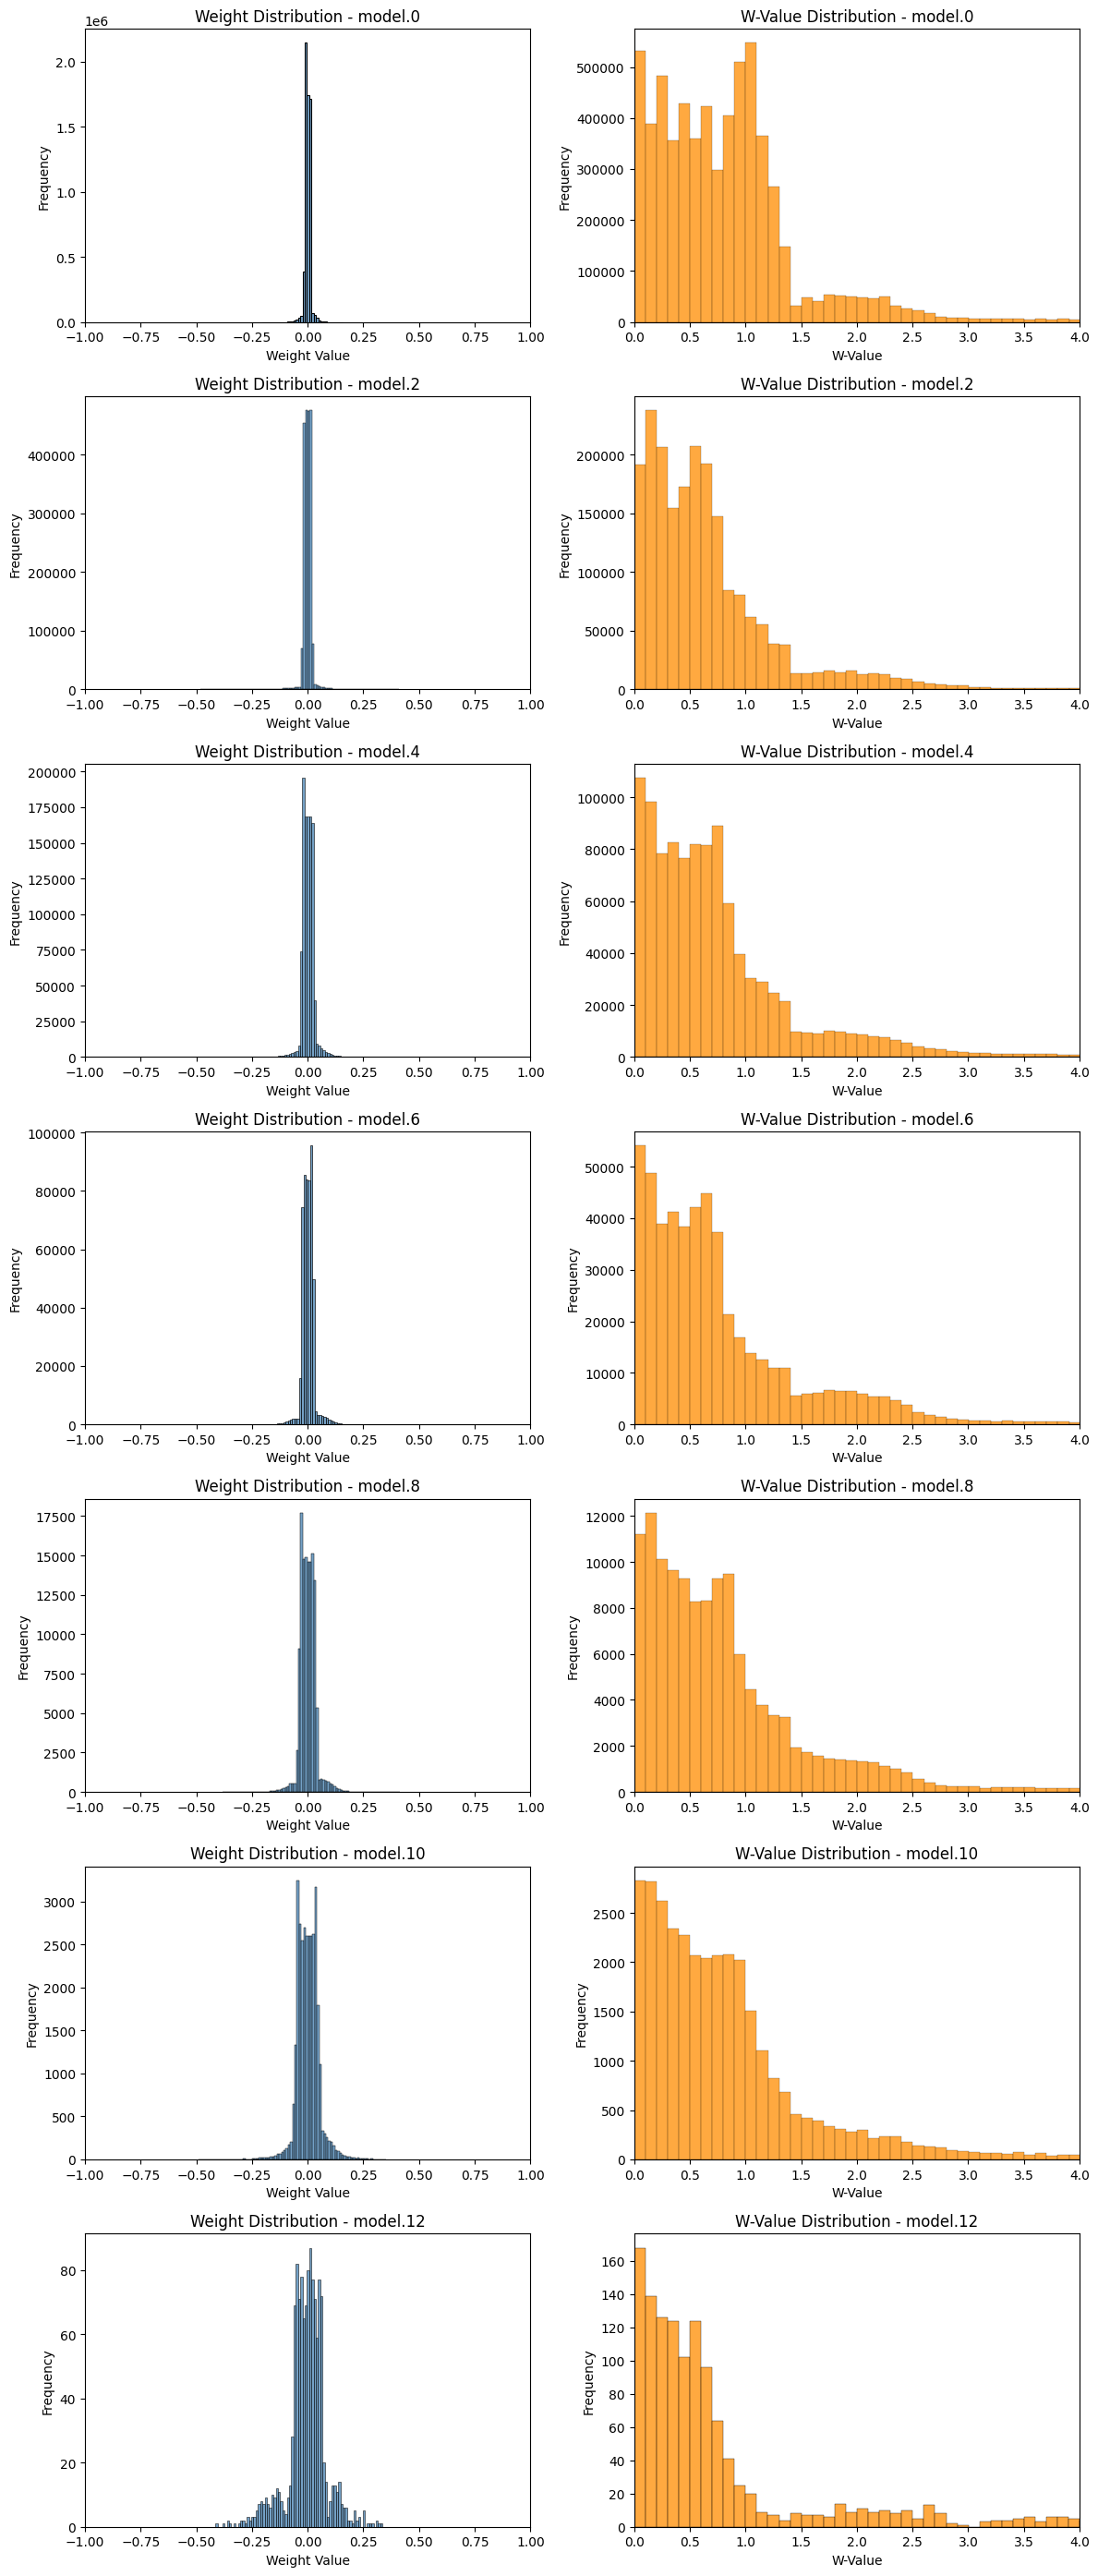

In [12]:
model = "ReLU_Mask_NoReg_t4"
plot_weight_distributions(model=model_results[model], model_name=model)

In [ ]:
model = "ReLU_NoMask_L1"
plot_weight_distributions(model=model_results[model], model_name=model)

In [ ]:
model = "ReLU_Mask_NoReg_t3"
plot_weight_distributions(model=model_results[model], model_name=model)

In [ ]:
model = "ReLU_Mask_NoReg_t5"
plot_weight_distributions(model=model_results[model], model_name=model)

In [14]:
m_75 = torch.load('runs/20250710_141920_act-ReLU_mask-True_thresh-0.69_reg-None_epochs-5-20Newsgroups/model.pth')